### This notebook is used to test the TensorFlow Serving API
* Use this code to deploy yolov3 model in `/tmp/yolov3` to a RESTful API with Docker `docker run -p 8501:8501 --mount type=bind,source=/tmp/yolov3/,target=/models/yolov3 -e MODEL_NAME=yolov3 -t tensorflow/serving &`
* The yolov3 SaveModel is created from this folder.
* THe RESTful API is `"http://localhost:8501/v1/models/yolov3:predict"`
* Use the same code to deploy an MNIST model `docker run -p 8501:8501 --mount type=bind,source=/Users/yuezha01/projects/RAID-Constellation/files_from_zak/models/mnist,target=/models/mnist -e MODEL_NAME=mnist -t tensorflow/serving &`
* The RESTful API is `"http://localhost:8501/v1/models/mnist:predict"`
* Check the metadata with `"http://localhost:8501/v1/models/mnist/metadata"`

### Test MNIST

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import requests
import tensorflow as tf
import json

In [ ]:
mnist = input_data.read_data_sets("mnist_data/", one_hot=True)
print(mnist.train.images.shape)
image_data_mnist = mnist.train.images[0]

In [ ]:
mnist_api = "http://localhost:8501/v1/models/mnist:predict"
image_data_mnist_list = image_data_mnist[np.newaxis, :].tolist()
headers = {"Content-type": "application/json"}
r = requests.post(mnist_api, headers=headers, 
                  data=json.dumps({"signature_name": "predict",
                                   "instances": image_data_mnist_list})).json()

In [ ]:
print(r)

### Test Yolov3

In [6]:
# the following session tests whether the session successfully load the variables
import cv2
from matplotlib import pyplot as plt
import numpy as np
import core.utils as utils

In [7]:
img_size = 608
num_channels = 3
image_path = "./docs/images/sample_computer.jpg"
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image_data = utils.image_preporcess(np.copy(original_image), [img_size, img_size])
print(image_data.shape)

(608, 608, 3)


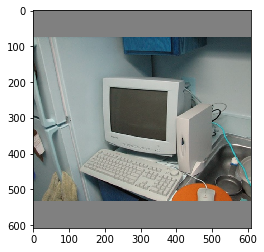

In [8]:
plt.imshow(image_data)
plt.show()

In [9]:
yolov3_api = "http://localhost:8501/v1/models/yolov3:predict"

In [12]:
image_data_yolo_list = image_data[np.newaxis, :].tolist()
headers = {"Content-type": "application/json"}
r = requests.post(yolov3_api, headers=headers, 
                  data=json.dumps({"signature_name": "predict",
                                   "instances": image_data_yolo_list})).json()

In [15]:
output = np.array(r['predictions'])
print(output.shape)
output = np.reshape(output, (-1, 85))
output.shape

(63, 19, 19, 85)


(22743, 85)

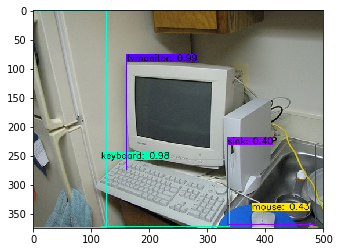

In [14]:
original_image_size = original_image.shape[:2]
bboxes = utils.postprocess_boxes(output, original_image_size, img_size, 0.3)
bboxes = utils.nms(bboxes, 0.45, method='nms')
image = utils.draw_bbox(original_image, bboxes)
plt.imshow(image)
plt.show()

### Test decode()

In [17]:
output_size = 13
y = tf.tile(tf.range(output_size, dtype=tf.int32)[:, tf.newaxis], [1, output_size])

# is it possible to direcly create a (13, 13) tensor?

In [18]:
y

<tf.Tensor 'Tile:0' shape=(13, 13) dtype=int32>

In [19]:
tf.range(13)

<tf.Tensor 'range_1:0' shape=(13,) dtype=int32>

In [20]:
x = tf.tile(tf.range(output_size, dtype=tf.int32)[tf.newaxis, :], [output_size, 1])

In [21]:
x

<tf.Tensor 'Tile_1:0' shape=(13, 13) dtype=int32>

In [24]:
xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)

In [25]:
xy_grid

<tf.Tensor 'concat:0' shape=(13, 13, 2) dtype=int32>

In [27]:
batch_size = -1
anchor_per_scale = 3
xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, anchor_per_scale, 1])

In [28]:
xy_grid

<tf.Tensor 'Tile_2:0' shape=(?, 13, 13, 3, 2) dtype=int32>

In [29]:
xy_grid = tf.cast(xy_grid, tf.float32)

In [30]:
xy_grid

<tf.Tensor 'Cast:0' shape=(?, 13, 13, 3, 2) dtype=float32>

#### why go through all these steps to create tensor? Is it that hard?

In [32]:
tf.range(13)

<tf.Tensor 'range_3:0' shape=(13,) dtype=int32>

In [33]:
with tf.Session() as sess:
    tmp1 = sess.run(tf.range(13))
    tmp2 = sess.run(x)

In [34]:
tmp1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)

In [35]:
tmp2

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]], dtype=int32)

In [39]:
import core.utils as utils
from core.config import cfg

In [41]:
anchors = utils.get_anchors(cfg.YOLO.ANCHORS)

In [42]:
anchors

array([[[ 1.25   ,  1.625  ],
        [ 2.     ,  3.75   ],
        [ 4.125  ,  2.875  ]],

       [[ 1.875  ,  3.8125 ],
        [ 3.875  ,  2.8125 ],
        [ 3.6875 ,  7.4375 ]],

       [[ 3.625  ,  2.8125 ],
        [ 4.875  ,  6.1875 ],
        [11.65625, 10.1875 ]]], dtype=float32)

In [45]:
anchors[0]

array([[1.25 , 1.625],
       [2.   , 3.75 ],
       [4.125, 2.875]], dtype=float32)

In [46]:
len(anchors[0])

3

In [44]:
print(cfg.YOLO.ANCHOR_PER_SCALE)
print(cfg.YOLO.IOU_LOSS_THRESH)

3
0.5
